# Art Style Transfer Project

## 1.1 Project Overview
The goal of this project is to create a deep learning model for art style transfer.
The model will take two images and transfer style of one image over the other.

### 1.2 Model Architecture
The model architecture consists of a generator neural network for artistic style transfer.
It takes input images (content and style) of size 64x64x3.
The generator comprises convolutional layers for initial processing,
concatenates content and style features, applies intermediate convolutional layers,
utilizes residual blocks for intricate feature enhancement, and employs upsampling layers.
The final convolutional layer produces a stylized image with RGB channels.
Loss functions include binary cross-entropy and perceptual loss, optimized using Adam.
The training loop minimizes pixel-wise losses and perceptual losses.
The model is designed for adapting the style of one image to another while preserving content.

## 2. Dataset Selection
The dataset utilized for training is ImageNet, a comprehensive repository of labeled images encompassing diverse categories.
ImageNet's extensive collection, known for its pivotal role in computer vision advancements, provides a rich and varied training environment.
The decision to use a 64x64 resolution stems from practical considerations, balancing computational efficiency and training speed.
This choice enables quicker model iteration and experimentation, making it an optimal resolution for the project's development .

## 4. Training

### 4.1 Train-Validation-Test Split
path of the training and testing data
Data\train_64x64\train_64x64
Data\test_64x64\test_64x64

### 4.2 Loss Functions
Used combination of l1 and l2, generator_loss, and perceptual_loss functions.

## 7. Examples and Visualizations
available in the folder:
Result Folder

## 8. Limitations and Potential Improvements
Limitations:
There is no proper reconsturction of the image.
There is not accurate transfer of style.
Potential Improvements:
Using a Discriminator
Utilizing mid-layer attributes for attribute transfer
Experimentation with the hyperparameters
To make a good style transfer

# Summary
To transfer the style from one image to another I have used a pixelwise loss for one image,
and perceptual loss for the style image.

In [1]:
# Import necessary libraries
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import os
from tensorflow.keras import layers

In [2]:
print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)

TensorFlow version: 2.10.0
NumPy version: 1.23.5
Matplotlib version: 3.5.2


In [3]:
# Check available GPU devices
devices = tf.config.list_physical_devices('GPU')
# tf.config.set_visible_devices(devices[0], 'GPU')
devices

[]

In [4]:

# Define a DataLoader class for loading and preprocessing image data
class DataLoader:
    def __init__(self, text_file_path, batch_size=20):
        #load the text file path
        self.text_file_path = text_file_path
        self.batch_size = batch_size

    def __iter__(self):
        #lists to stack images and styles
        images = []
        styles = []
        with open(self.text_file_path, "r") as f:
            for line in f:
                # Read and preprocess image and style paths
                image_path, style_path = line.strip().split()
                image = self.parse_image(image_path, 3, 64)
                style = self.parse_image(style_path, 3, 64)

                images.append(image)
                styles.append(style)

                # Yield batches of data when batch size is reached
                if len(images) == self.batch_size:
                    yield tf.stack(images), tf.stack(styles)
                    images = []
                    styles = []

    def parse_image(self, image_path, channel, resolution):
        # Read, decode, resize, and normalize image
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=channel)
        image = tf.image.resize(image, [resolution, resolution])
        image = (image - 127.5) / 127.5
        return image

In [5]:
# Prepare paths and create a text file containing paths of the images

# datafile = r"Data\lite"
datafile = r"Data\train_64x64\train_64x64" # data folder path
path_Data = "paths.txt" #paht folder path

lst = os.listdir(datafile) 
lst = [os.path.join(r"Data\train_64x64\train_64x64",i) for i in lst]
# use half of them as images and half of them as styles
one,two = lst[:int(len(lst)/2)],lst[int(len(lst)/2):] 
with open(path_Data,'w') as f:
    for i,j in zip(one,two):
        f.write('{} {} \n'.format(i,j))

In [6]:
len(lst) # total number of images

1281149

(5, 64, 64, 3) (5, 64, 64, 3)


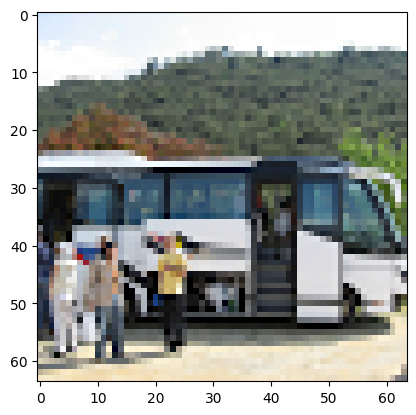

In [7]:
# Shuffle paths
with open(path_Data, 'r') as file:
    lines = file.readlines()
random.shuffle(lines)
with open(path_Data, 'w') as file:
    file.writelines(lines)

# create DataLoader instance
batch_size = 5
dataset = DataLoader(path_Data, batch_size)

#check one instance of dataset
for x, y in dataset:
    print(x.shape, y.shape)
    plt.imshow(x[0]/ 2 + 0.5)
    break


In [8]:
# Define a residual block function for the generator model
def residual_block(inputs, filters, kernel_size=3):
    x = layers.Conv2D(filters, kernel_size=kernel_size, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Add()([x, inputs])

    return outputs

# Define the generator model for style transfer
def build_generator():
    # Input layers for content and style images
    image_attribute = layers.Input(shape=(64, 64, 3), name='image_input')
    style_attribute = layers.Input(shape=(64, 64, 3), name='style_input')

    # Encoding paths through convolutional layers
    x1 = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(image_attribute)
    x1 = layers.Activation('relu')(x1)
    x1 = layers.BatchNormalization()(x1)
    x2 = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(style_attribute)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.BatchNormalization()(x2)

    # Concatenate encoded paths
    x = layers.Concatenate()([x1, x2])

    # Additional convolutional layers and residual blocks
    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)

    for _ in range(1): # number of residual blocks
        x = residual_block(x, 128)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, kernel_size=(3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    for _ in range(1): 
        x = residual_block(x, 128)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, kernel_size=(3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    for _ in range(1): 
        x = residual_block(x, 128, 5)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, kernel_size=(3, 3), padding='same')(x)

    # Output layer for generated image
    outputs = layers.Conv2D(3, kernel_size=(3, 3), padding='same', activation='tanh')(x)

    # Define the generator model
    model = tf.keras.models.Model([image_attribute, style_attribute],
                                  outputs, name="Generator")

    return model

In [9]:
# Load pre-trained VGG16 model for perceptual loss
vgg16 = tf.keras.models.load_model(
    r"model_weights\vgg16.h5")
vgg16.trainable = False
# Load the generator model
generator = build_generator()

In [10]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [11]:
vgg16(x).shape

TensorShape([5, 2, 2, 512])

In [12]:
for i in vgg16.layers : 
    if 'conv' in i.name.lower():
        print(i)

In [13]:
# Create a new model that includes only the convolutional layers up to a specific layer

layer_outputs = [vgg16.get_layer(layer_name.name).output for layer_name in vgg16.layers[1:] if 'conv' in layer_name.name.lower()]
activation_model = tf.keras.models.Model(inputs=vgg16.input, outputs=layer_outputs)

# Get the activations of the layers for the input image
activations = activation_model.predict(x)

# Display the first feature map of each layer
for layer_activation in activations:
    print(layer_activation[:,:,:,0].shape)

1/1 [==============================] - 0s 173ms/step
(5, 64, 64)
(5, 64, 64)
(5, 32, 32)
(5, 32, 32)
(5, 16, 16)
(5, 16, 16)
(5, 16, 16)
(5, 8, 8)
(5, 8, 8)
(5, 8, 8)
(5, 4, 4)
(5, 4, 4)
(5, 4, 4)


In [14]:
activation_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [15]:
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 style_input (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['image_input[0][0]']            
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   1792        ['style_input[0][0]']            
                                                                                          

In [16]:
# Define optimizer and loss function for the generator
generator_optimizer = tf.keras.optimizers.Adam(0.001)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:

#Loss Functions
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def perceptual_loss(real_images, generated_images,get_feats):
    real_features = activation_model(real_images)
    generated_features = activation_model(generated_images)
    loss= tf.constant(0.0)
    if get_feats:
        for i,j in zip(real_features,generated_features):
            loss += tf.reduce_mean(tf.square(i[:,:,:,0]-j[:,:,:,0]))
    else :
        for i,j in zip(real_features,generated_features):
            loss += tf.reduce_mean(tf.square(i[:,:,:,1:]-j[:,:,:,1:]))
    return loss

def l1_l2(real, gen):
    mae_loss = tf.reduce_mean(tf.abs(real - gen))
    rmse_loss = tf.sqrt(tf.reduce_mean(tf.square(real - gen)))
    total_loss = mae_loss + rmse_loss
    return total_loss


In [18]:
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 style_input (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['image_input[0][0]']            
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   1792        ['style_input[0][0]']            
                                                                                          

In [19]:
# Function to generate and save images during training
def generate_and_save_images(epoch, step, image, style, save_fig=True):
    # Generate images using the trained generator
    gen_image = generator(
        [image, style], training=False)

    # Create a figure for visualization
    fig = plt.figure(figsize=(12, 12))  # figsize=(12, 12)

    # Number of images to display
    num_images = 5

    # Display generated images, input images (content and style)
    for i in range(num_images):
        plt.subplot(4, 5, i + 1)
        plt.imshow(gen_image[i, :, :, :] / 2 + 0.5)
        plt.axis("off")
        plt.title(f"Generated {i + 1}")

    for i in range(num_images):
        plt.subplot(4, 5, num_images + i + 1)
        plt.imshow(image[i, :, :, :] / 2 + 0.5)
        plt.axis("off")
        plt.title(f"Image {i + 1}")

    for i in range(num_images):
        plt.subplot(4, 5, 2 * num_images + i + 1)
        plt.imshow(style[i, :, :, :] / 2 + 0.5)
        plt.axis("off")
        plt.title(f"Style {i + 1}")

    # Save or display the figure
    if save_fig:
        save_dir = "results"
        plt.savefig(
            save_dir + "/image_at_epoch_{:04d}_{:04d}.png".format(epoch, step))
        plt.close(fig)
    else:
        plt.show()

In [22]:
# TensorFlow function to perform a training step
@tf.function
def train_step(image, style, lambda_l1_l2, lambda_percep):

    with tf.GradientTape() as generator_tape:
        # Generate images using the generator
        gen_image = generator(
            [image, style], training=True)

        # Compute pixel and perceptual losses
        image_pixel_loss = l1_l2(image, gen_image)*lambda_l1_l2
        style_pixel_loss = l1_l2(style, gen_image)*lambda_l1_l2
    
        image_percep_loss = perceptual_loss(image, gen_image, True) * lambda_percep
        style_percep_loss = perceptual_loss(style, gen_image, False) * lambda_percep

        # Calculate total generator loss
        generator_loss = image_percep_loss + style_percep_loss

        # Get the gradients for the generators
        grads_generator = generator_tape.gradient(
            generator_loss, generator.trainable_variables)

        # Update the weights of the generators
    generator_optimizer.apply_gradients(
        zip(grads_generator, generator.trainable_variables)
    )
    # Return losses for monitoring
    return generator_loss, image_pixel_loss , style_pixel_loss , image_percep_loss , style_percep_loss


# Function to perform training over multiple epochs
def train(dataset, start, end):
    for epoch in range(start, end):
        start_epoch = time.time()
        i = 0
        lambda_l1_l2 = 2
        lambda_percep = 7

        # Iterate over batches in the dataset
        for image, style in dataset:
            start_step = time.time()

            # Display sample generated images at the beginning of training
            if i == 0:
                generate_and_save_images(
                    epoch+1, i, image, style)
                
            # Perform a training step and get losses
            generator_loss, image_pixel_loss , style_pixel_loss , image_percep_loss , style_percep_loss= train_step(
                image, style , lambda_l1_l2, lambda_percep)
            
            # Display training progress
            print("Step: {} Epoch: {}".format(i, epoch))
            print("Total Loss : {}".format(generator_loss))
            print("Pixel Loss Image: {} Style: {}".format(image_pixel_loss,style_pixel_loss))
            print("Perceptual Loss Image: {} Style: {}".format(image_percep_loss,style_percep_loss))
            print("time step: {}".format(time.time() - start_step))

            # Save generated images periodically during training
            if i % 100 == 0:
                generator.save(f"model_weights/model.h5")
                generate_and_save_images(
                    epoch+1, i, image,style)
            i += 1
        # Display time taken for the current epoch
        print("time epoch: {}".format(time.time() - start_epoch))

    # Display total number of epochs completed
    print("epoch: {}".format(epoch + 1))

In [23]:
# Load pre-trained generator model
generator = tf.keras.models.load_model(f"model_weights/model.h5")

# Record the time taken for training
train_time=time.time()

# Train the model for a specified number of epochs
train(dataset, 4, 5)

# Display total time taken for training
print("total time taken to train : ", time.time()-train_time)

Step: 0 Epoch: 4
Total Loss : 7089.146484375
Pixel Loss Image: 1.1713266372680664 Style: 2.8585424423217773
Perceptual Loss Image: 1198.789794921875 Style: 5890.3564453125
time step: 3.5881950855255127
Step: 1 Epoch: 4
Total Loss : 6042.3671875
Pixel Loss Image: 0.8731929659843445 Style: 2.789339065551758
Perceptual Loss Image: 1092.640380859375 Style: 4949.72705078125
time step: 0.41477036476135254
Step: 2 Epoch: 4
Total Loss : 6265.345703125
Pixel Loss Image: 1.1349366903305054 Style: 1.986783504486084
Perceptual Loss Image: 1585.542236328125 Style: 4679.80322265625
time step: 0.4755876064300537
Step: 3 Epoch: 4
Total Loss : 5601.31982421875
Pixel Loss Image: 1.2781944274902344 Style: 1.8904445171356201
Perceptual Loss Image: 1291.55078125 Style: 4309.76904296875
time step: 0.43628740310668945
Step: 4 Epoch: 4
Total Loss : 5525.23046875
Pixel Loss Image: 1.3741376399993896 Style: 2.1083743572235107
Perceptual Loss Image: 1666.4967041015625 Style: 3858.73388671875
time step: 0.4495635

KeyboardInterrupt: 

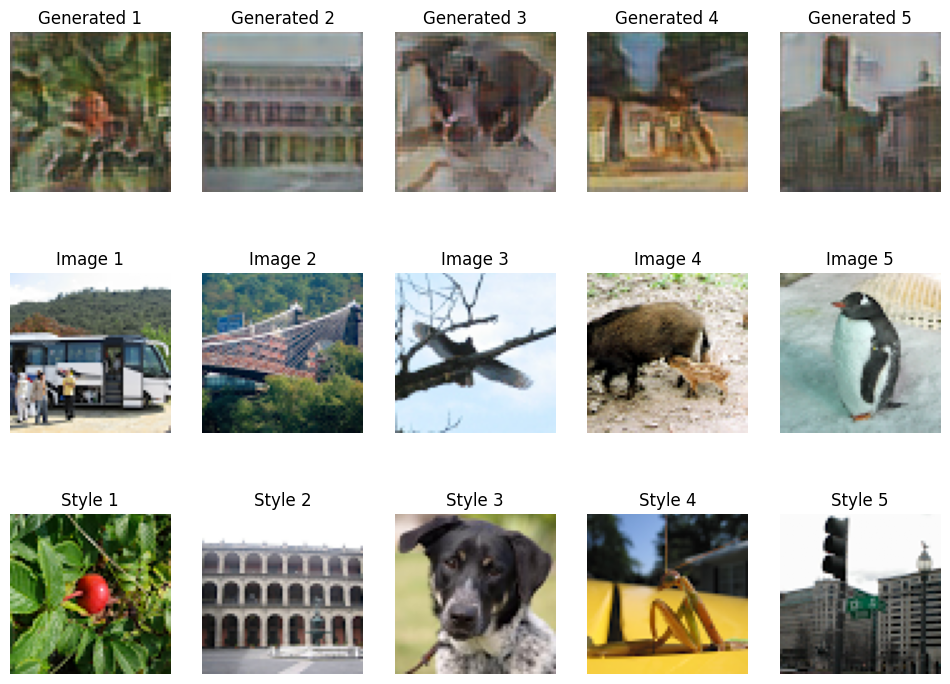

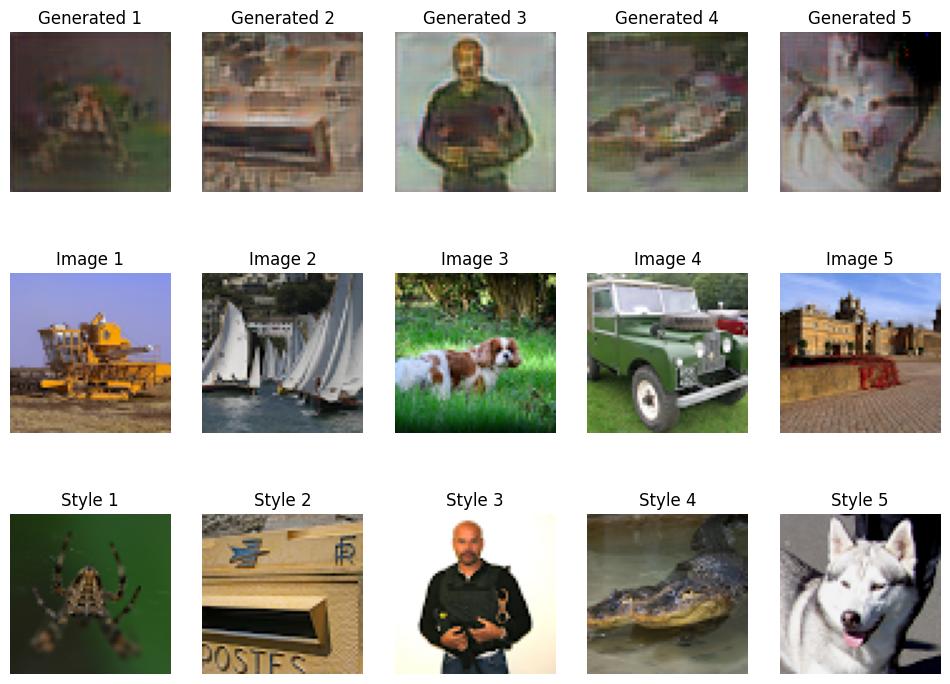

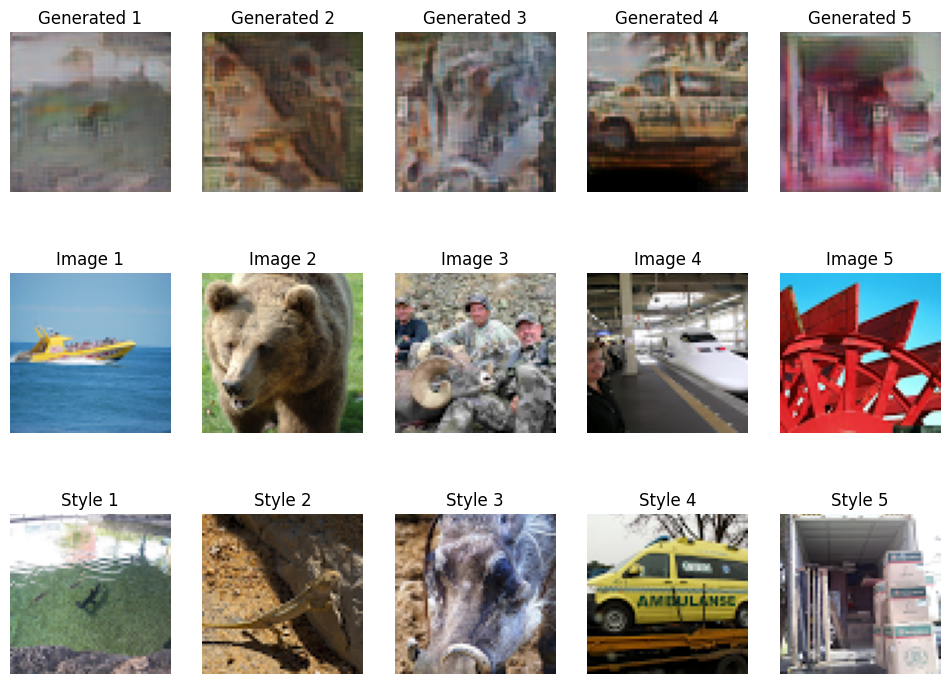

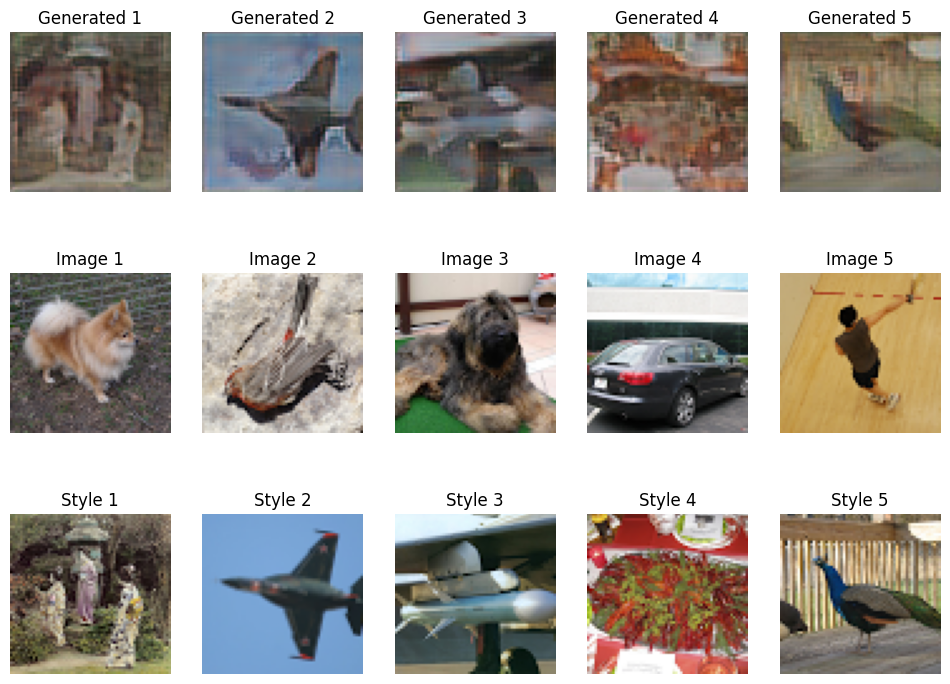

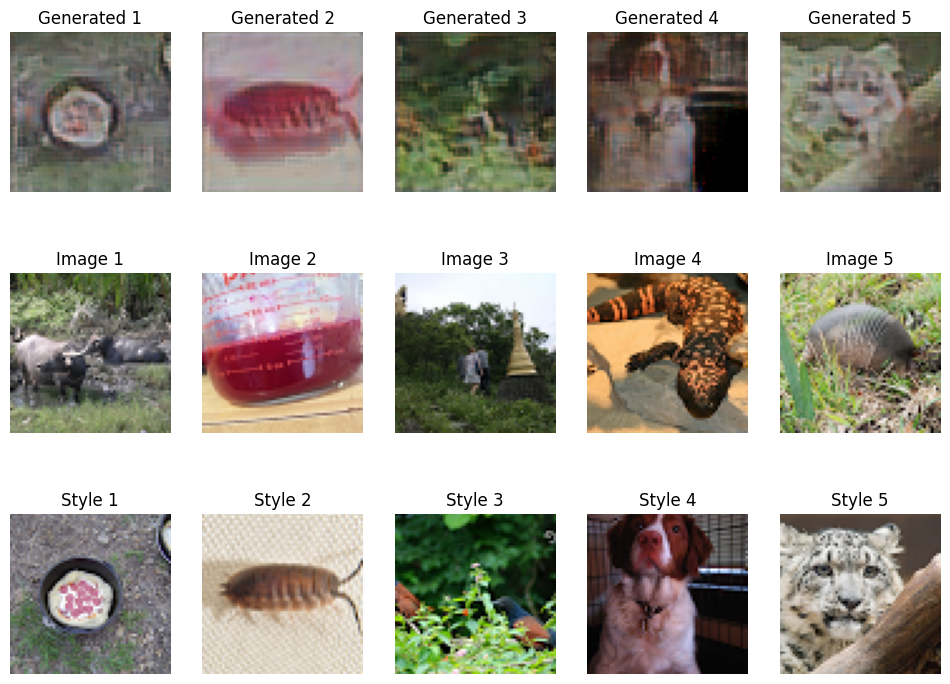

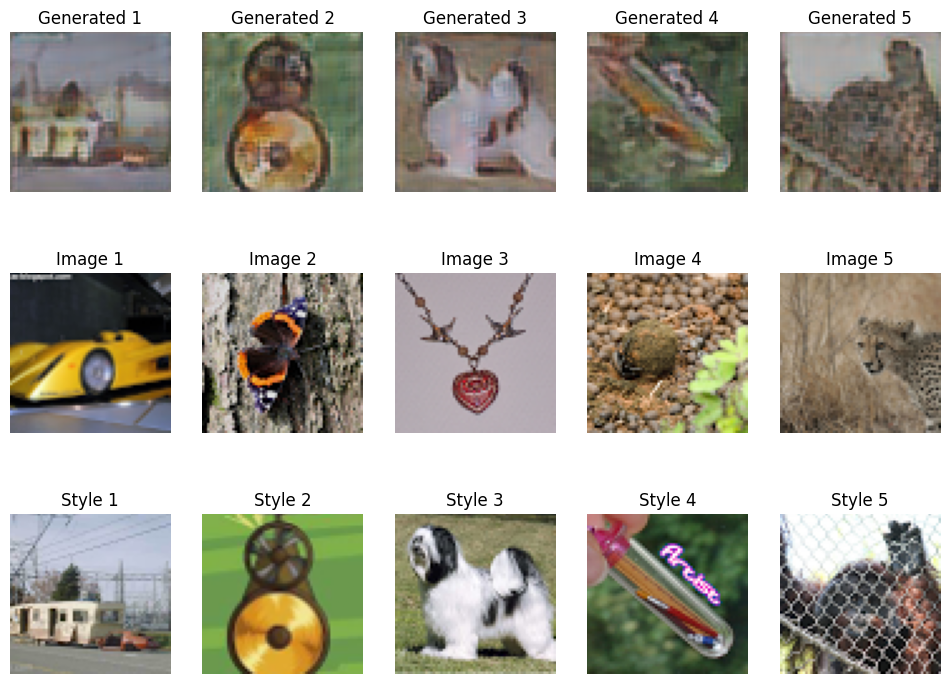

In [24]:
length = 5
i = 0
for image, style in dataset:
    if i >length:
        break
    generate_and_save_images(0, 0, image,style,False)
    i+=1